# **Quá trình trích chọn đặc trưng cho bộ dữ liệu**

## import các thư viện và kết nối các file

In [ ]:
import dlib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import os
from math import sqrt
from math import acos
import pandas as pd

In [ ]:
#kết nối google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# địa chỉ path
path_haarcascade = "/content/gdrive/MyDrive/DPT/assets/haarcascade.xml"
path_faciallandmark = "/content/gdrive/MyDrive/DPT/assets/shape_predictor_68_face_landmarks.dat"

In [ ]:
predict_68 = dlib.shape_predictor(path_faciallandmark)
detector = dlib.get_frontal_face_detector()

In [ ]:
data_dir = "/content/gdrive/MyDrive/DPT/dataset"

## đọc dữ liêu và sắp xếp

In [ ]:
# # đổi tên data theo thứ tự
# for i, filename in enumerate(os.listdir(data_dir)):
#   # Tạo tên tệp mới
#   if i < 9:
#       new_filename = f'image_00{i+1}.jpg'
#   elif i < 99:
#       new_filename = f'image_0{i+1}.jpg'
#   else:
#       new_filename = f'image_{i+1}.jpg'

#   # Đường dẫn đến tệp cũ và tệp mới
#   old_path = os.path.join(data_dir, filename)
#   new_path = os.path.join(data_dir, new_filename)

#   # Đổi tên tệp
#   os.rename(old_path, new_path)
#   print(f'Đã đổi tên {filename} thành {new_filename}')

Đã đổi tên image_001.jpg thành image_001.jpg
Đã đổi tên image_002.jpg thành image_002.jpg
Đã đổi tên image_005.jpg thành image_003.jpg
Đã đổi tên image_004.jpg thành image_004.jpg
Đã đổi tên image_007.jpg thành image_005.jpg
Đã đổi tên image_008.jpg thành image_006.jpg
Đã đổi tên image_009.jpg thành image_007.jpg
Đã đổi tên image_010.jpg thành image_008.jpg
Đã đổi tên image_011.jpg thành image_009.jpg
Đã đổi tên image_012.jpg thành image_010.jpg
Đã đổi tên image_013.jpg thành image_011.jpg
Đã đổi tên image_014.jpg thành image_012.jpg
Đã đổi tên image_015.jpg thành image_013.jpg
Đã đổi tên image_016.jpg thành image_014.jpg
Đã đổi tên image_017.jpg thành image_015.jpg
Đã đổi tên image_018.jpg thành image_016.jpg
Đã đổi tên image_019.jpg thành image_017.jpg
Đã đổi tên image_020.jpg thành image_018.jpg
Đã đổi tên image_021.jpg thành image_019.jpg
Đã đổi tên image_022.jpg thành image_020.jpg
Đã đổi tên image_023.jpg thành image_021.jpg
Đã đổi tên image_024.jpg thành image_022.jpg
Đã đổi tên

In [ ]:
# đọc data
images = []
for filename in os.listdir(data_dir):
  img = cv.imread(os.path.join(data_dir, filename))
  images.append((filename, img))


In [ ]:
len(images)

113

In [ ]:
#sắp xếp data theo tên từ bé đến lớn
images.sort(key=lambda x: x[0])

In [ ]:
images[15][0]

'image_016.jpg'

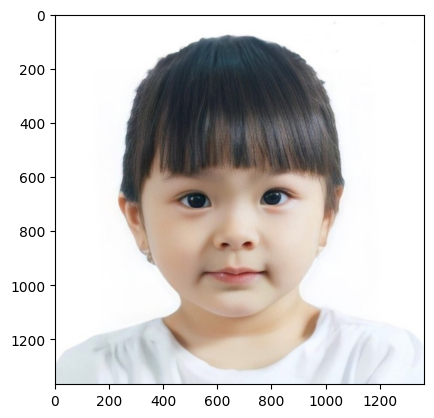

In [ ]:
plt.imshow(cv.cvtColor(images[5][1], cv.COLOR_BGR2RGB))

## trích chọn đặc trưng màu da

In [ ]:
# xóa các mảng đen không phải màu da
def removeBlack(estimator_labels, estimator_cluster):
  hasBlack = False
  # Lấy tổng số lần xuất hiện của mỗi màu
  occurance_counter = Counter(estimator_labels)

  compare = lambda x, y: Counter(x) == Counter(y)
  black_threshold = 20
  mask = np.all(estimator_cluster > black_threshold,axis=1)
  estimator_cluster = estimator_cluster[mask]
  print(mask)
  for i in range(len(mask)):
    if mask[i] == False :
      del occurance_counter[i]
  hasBlack = True

  return (occurance_counter,estimator_cluster,hasBlack)


In [ ]:
#lấy thông tin màu da
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):

  occurance_counter = None

  colorInformation = []

  #Check for Black
  hasBlack =True

  # if hasThresholding == True:

  #   (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
  #   occurance_counter =  occurance
  #   estimator_cluster = cluster
  #   hasBlack = black

  # else:
  #   occurance_counter = Counter(estimator_labels)
  (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
  occurance_counter =  occurance
  estimator_cluster = cluster
  hasBlack = black
  # tổng mẫu dự đoán
  totalOccurance = sum(occurance_counter.values())

  # Lặp lại tất cả các màu được dự đoán
  for x in occurance_counter.most_common(len(estimator_cluster)):

    index = (int(x[0]))

    # sửa chỉ mục nếu có xóa màu đen
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

    # chỉ số màu sách rgb
    color = estimator_cluster[index].tolist()

    # phần trăm của màu sắc
    color_percentage= (x[1]/totalOccurance)

    #thông tin màu sắc
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

    colorInformation.append(colorInfo)

  return colorInformation

In [ ]:
def plotColorBar(colorInformation):
  color_bar = np.zeros((100,500,3), dtype="uint8")

  top_x = 0
  for x in colorInformation:
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))

    cv.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

In [ ]:
#tìm kiếm khuân mặt
def face_detection(img):
  #tìm các gương mặt trong hình
  faces = detector(img, 0)
  # nếu tìm thấy ít nhất một mặt
  if len(faces) > 0:
    return img[faces[0].top():faces[0].bottom(), faces[0].left():faces[0].right()]
  else:
    return img

In [ ]:
# trích vùng màu da
def extract_skin(img):
  # đổi ảnh sang chuẩn màu HSV
  img_HSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  # đặt ngưỡng màu da cho HSV
  HSV_mask = cv.inRange(img_HSV, (0, 15, 0), (17,170,255))
  HSV_mask = cv.morphologyEx(HSV_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

  # đổi ảnh sang YCrCb
  img_YCrCb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
  #đặt ngưỡng
  YCrCb_mask = cv.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
  YCrCb_mask = cv.morphologyEx(YCrCb_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

  #gộp hai mask
  global_mask=cv.bitwise_and(YCrCb_mask,HSV_mask)
  global_mask=cv.GaussianBlur(global_mask,(3,3),0)

  skin  =  cv.bitwise_and(img,img,mask=global_mask)
  return skin


In [ ]:
#trích các màu sắc chủ đạo của da
def extractDominantColor(image,number_of_colors,hasThresholding=False):
  # + 1 cụm màu đen
  if hasThresholding == True:
    number_of_colors +=1

  img = image.copy()

  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  estimator.fit(img)

  print(estimator.cluster_centers_)
  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation


### ví dụ 1 xử lý 1 ảnh

In [ ]:
img = images[28][0]

In [ ]:
img = images[0][1]

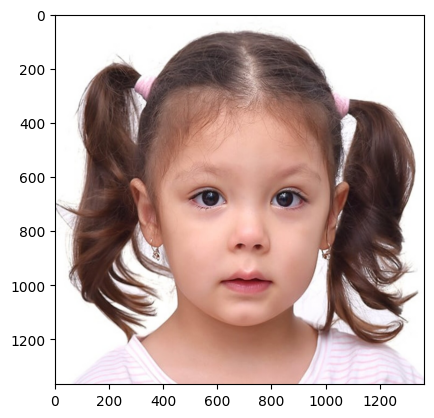

In [ ]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [ ]:
face_img = face_detection(img)

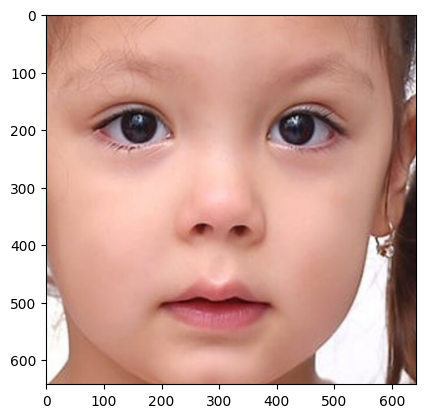

In [ ]:
plt.imshow(cv.cvtColor(face_img, cv.COLOR_BGR2RGB))

In [ ]:
extract_img = extract_skin(face_img)

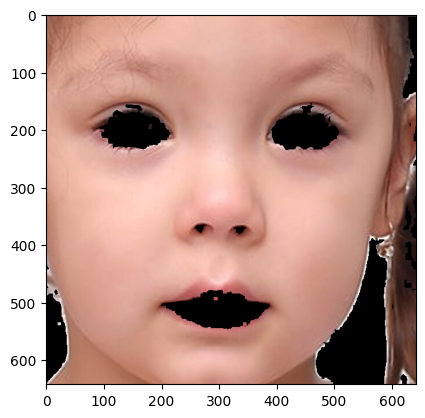

In [ ]:
plt.imshow(cv.cvtColor(extract_img,cv.COLOR_BGR2RGB))

In [ ]:
dominantColors = extractDominantColor(extract_img,number_of_colors=2 ,hasThresholding=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[181.55600543 126.77924768 111.38067813]
 [ 24.00595749  14.56241858  12.52182823]
 [228.77073009 175.43235545 160.50804139]]
[ True False  True]


In [ ]:
dominantColors

[{'cluster_index': 1,
  'color': [228.77073008642492, 175.4323554543177, 160.50804139366193],
  'color_percentage': 0.6032438747809353},
 {'cluster_index': 0,
  'color': [181.55600542733035, 126.77924767967168, 111.38067812756525],
  'color_percentage': 0.3967561252190646}]

In [ ]:
dominantColors[0]['color']

[228.77073008642492, 175.4323554543177, 160.50804139366193]

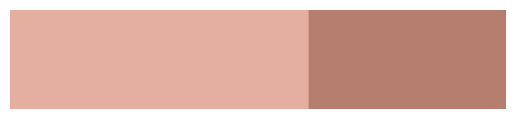

In [ ]:
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)

### trích đặc trưng màu da của bộ dữ liệu

In [ ]:
def extract_dominant_color(images):
  dominantSkinColors = []

  for img in images:
    print("********", img[0])
    face_img = face_detection(img[1])
    extract_img = extract_skin(face_img)
    dominantColors = extractDominantColor(extract_img,number_of_colors=2 ,hasThresholding=True)
    dominantSkinColors.append(dominantColors[0]['color'])
  return dominantSkinColors


## trích chọn đặc trưng điểm khuân mặt

In [ ]:
def face_points(img):
  img2 = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  faces = detector(img, 0)
  for face in faces:
    landmarks = predict_68(img, face)
    #mui
    mui_x = landmarks.part(30).x
    mui_y = landmarks.part(30).y
    #mat trai ngoai
    mat_trai_ngoai_x = landmarks.part(36).x
    mat_trai_ngoai_y = landmarks.part(36).y
    #mat trai trong
    mat_trai_trong_x = landmarks.part(39).x
    mat_trai_trong_y = landmarks.part(39).y
    #mat phai trong
    mat_phai_trong_x = landmarks.part(42).x
    mat_phai_trong_y = landmarks.part(42).y
    #mat phai ngoai
    mat_phai_ngoai_x = landmarks.part(45).x
    mat_phai_ngoai_y = landmarks.part(45).y
    #moi trai
    moi_trai_x = landmarks.part(48).x
    moi_trai_y = landmarks.part(48).y
    #moi phai
    moi_phai_x = landmarks.part(54).x
    moi_phai_y = landmarks.part(54).y

    pointInfo = {"mui_x":mui_x , "mui_y": mui_y ,
                 "mat_trai_ngoai_x" : mat_trai_ngoai_x, "mat_trai_ngoai_y" : mat_trai_ngoai_y,
                 "mat_trai_trong_x" : mat_trai_trong_x, "mat_trai_trong_y" : mat_trai_trong_y,
                 "mat_phai_trong_x" : mat_phai_trong_x, "mat_phai_trong_y" : mat_phai_trong_y,
                 "mat_phai_ngoai_x" : mat_phai_ngoai_x, "mat_phai_ngoai_y" : mat_phai_ngoai_y,
                 "moi_trai_x" : moi_trai_x, "moi_trai_y" : moi_trai_y,
                 "moi_phai_x" : moi_phai_x, "moi_phai_y" : moi_phai_y  }
  return pointInfo


In [ ]:
def caculate_triangle(a,b,c):
  s = (a+b+c)/2
  area = sqrt(s*(s-a)*(s-b)*(s-c))
  a1 = acos((b*b+c*c-a*a)/(2*b*c))
  a2 = acos((a*a+c*c-b*b)/(2*a*c))
  a3 = acos((a*a+b*b-c*c)/(2*a*b))
  return area,a1,a2,a3


In [ ]:
def caculate_points(img):
  pointInfo = face_points(img)
  mui_x = pointInfo["mui_x"]
  mui_y = pointInfo["mui_y"]
  mat_trai_ngoai_x = pointInfo["mat_trai_ngoai_x"]
  mat_trai_ngoai_y = pointInfo["mat_trai_ngoai_y"]
  mat_trai_trong_x = pointInfo["mat_trai_trong_x"]
  mat_trai_trong_y = pointInfo["mat_trai_trong_y"]
  mat_phai_trong_x = pointInfo["mat_phai_trong_x"]
  mat_phai_trong_y = pointInfo["mat_phai_trong_y"]
  mat_phai_ngoai_x = pointInfo["mat_phai_ngoai_x"]
  mat_phai_ngoai_y = pointInfo["mat_phai_ngoai_y"]
  moi_trai_x = pointInfo["moi_trai_x"]
  moi_trai_y = pointInfo["moi_trai_y"]
  moi_phai_x = pointInfo["moi_phai_x"]
  moi_phai_y = pointInfo["moi_phai_y"]

  #a1-a2
  d1 = sqrt(pow(mat_trai_trong_x - mat_trai_ngoai_x,2) + pow(mat_trai_trong_y - mat_trai_ngoai_y,2))
  #a1-a3, a13-a14
  d2 = sqrt(pow(mat_trai_ngoai_x - mui_x,2) + pow(mat_trai_ngoai_y - mui_y,2))
  #a2-a3,a4-a6
  d3 = sqrt(pow(mat_trai_trong_x - mui_x,2) + pow(mat_trai_trong_y - mui_y,2))
  #a4-a5
  d4 = sqrt(pow(mat_trai_trong_x - mat_phai_trong_x,2) + pow(mat_trai_trong_y - mat_phai_trong_y,2))
  #a5-a6, a7-a9
  d5 = sqrt(pow(mat_phai_trong_x - mui_x,2) + pow(mat_phai_trong_y - mui_y,2))
  #a7-a8
  d6 = sqrt(pow(mat_phai_trong_x - mat_phai_ngoai_x,2) + pow(mat_phai_trong_y - mat_phai_ngoai_y,2))
  #a8-a9, a10-a11
  d7 = sqrt(pow(mat_phai_ngoai_x - mui_x,2) + pow(mat_phai_ngoai_y - mui_y,2))
  #a10-a12
  d8 = sqrt(pow(mat_phai_ngoai_x - moi_phai_x,2) + pow(mat_phai_ngoai_y - moi_phai_y,2))
  #a11-a12,a16-a18
  d9 = sqrt(pow(moi_phai_x - mui_x,2) + pow(moi_phai_y - mui_y,2))
  #a17-a18
  d10 = sqrt(pow(moi_phai_x - moi_trai_x,2) + pow(moi_phai_y - moi_trai_y,2))
  #a16-a17,a14-a15
  d11 = sqrt(pow(moi_trai_x - mui_x,2) + pow(moi_trai_y - mui_y,2))
  #a13-a15
  d12 = sqrt(pow(moi_trai_x - mat_trai_ngoai_x,2) + pow(moi_trai_y - mat_trai_ngoai_y,2))

  A1, a1, a2, a3 = caculate_triangle(d3,d2,d1)
  A2, a4, a5, a6 = caculate_triangle(d5,d3,d4)
  A3, a7, a8, a9 = caculate_triangle(d7,d5,d6)
  A5, a10, a11, a12 = caculate_triangle(d9,d8,d7)
  A4, a13, a14, a15 = caculate_triangle(d11,d12,d2)
  A6, a16, a17, a18 = caculate_triangle(d10,d9,d11)
  return [A1,A2,A3,A4,A5,A6,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18]

In [ ]:
def extract_landmark(images):
  extractLandmarks = []
  for img in images:
    print("********", img[0])
    landmarkInfo = caculate_points(img[1])
    extractLandmarks.append(landmarkInfo)
  return extractLandmarks


## tiến hành trích chọn đặc trưng

In [ ]:
extractDominantColor = extract_dominant_color(images)

******** image_001.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[181.55600543 126.77924768 111.38067813]
 [ 24.00595749  14.56241858  12.52182823]
 [228.77073009 175.43235545 160.50804139]]
[ True False  True]
******** image_002.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[224.33538286 183.85480326 159.89184509]
 [ 13.66547609   7.36877048   5.67455248]
 [178.42275335 126.13197291  99.76232797]]
[ True False  True]
******** image_003.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[215.5839257  186.0866306  167.44323136]
 [ 13.23510748   8.76527238   6.4148456 ]
 [182.72997324 147.12341637 124.67063516]]
[ True False  True]
******** image_004.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[227.84417703 177.85268606 159.92696355]
 [  2.1339855    1.48157296   1.39428867]
 [161.18865106 115.39496275 100.14576637]]
[ True False  True]
******** image_005.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[205.02282453 167.15191974 141.51021671]
 [  5.98579641   3.67693104   2.73954213]
 [152.57180816 107.12686983  83.09681308]]
[ True False  True]
******** image_006.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[211.78851106 187.44612166 169.15029329]
 [  4.16403228   3.10157839   2.62680811]
 [148.82468658 116.48282105  98.97717218]]
[ True False  True]
******** image_007.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[200.31184188 159.26656511 140.10752328]
 [  2.4226297    1.61634284   1.41754141]
 [144.19694144 103.01361432  86.83272204]]
[ True False  True]
******** image_008.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  3.99783463   2.36973745   1.70160281]
 [167.78870702 131.64774529 112.13970496]
 [126.93453453  91.57473144  74.74542394]]
[False  True  True]
******** image_009.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[154.35186646 114.03002479 110.43818537]
 [  0.54078038   0.29430897   0.2885826 ]
 [224.2684854  180.80403338 177.39955347]]
[ True False  True]
******** image_010.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[193.65558721 138.12242673 116.63990252]
 [221.81757848 183.70876101 168.39598436]
 [ 37.58307329  22.19309693  17.2       ]]
[ True  True False]
******** image_011.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[220.74864936 168.80910759 158.91043155]
 [ 17.31467305  10.16377839   8.67181703]
 [170.64883467 123.15319677 110.10693258]]
[ True False  True]
******** image_012.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[133.49463104  82.47349854  54.65621675]
 [  4.04190843   2.26947854   1.62512624]
 [180.93082362 125.28325982  96.48901976]]
[ True False  True]
******** image_013.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  6.51891508   3.34713651   2.48619168]
 [227.6809178  187.12409891 155.61474716]
 [182.7134453  131.32892317 108.65130433]]
[False  True  True]
******** image_014.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.4997134    1.57170698   1.42382208]
 [219.77169442 176.56350875 169.77781807]
 [190.3146204  131.38036455 119.09251158]]
[False  True  True]
******** image_015.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[242.84328193 202.33958963 180.82379042]
 [  6.79651071   3.92954474   2.98050567]
 [205.82199821 153.51421337 124.68333786]]
[ True False  True]
******** image_016.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[174.04422347 127.28351107  93.55596418]
 [  5.67839459   3.64491615   2.34733504]
 [214.34524484 174.39358868 143.19840757]]
[ True False  True]
******** image_017.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[166.70376384 137.94832241 120.3136447 ]
 [  3.308727     2.12550072   1.78298452]
 [203.76888042 179.48842228 165.67825128]]
[ True False  True]
******** image_018.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[228.61665664 188.84367016 170.64638115]
 [  5.76520672   3.95515328   3.35987318]
 [200.90786436 155.26693362 136.13476912]]
[ True False  True]
******** image_019.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[149.63088812 109.81704266 101.02696115]
 [  1.10179663   0.70374348   0.62262464]
 [184.79550372 154.41951197 145.18062854]]
[ True False  True]
******** image_020.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[215.62346791 182.51394367 169.55098423]
 [  3.42861608   2.06314654   1.74492347]
 [176.19671319 136.85442397 121.3856091 ]]
[ True False  True]
******** image_021.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.51985219   1.43048982   1.00778363]
 [207.94478217 169.24825953 137.96173832]
 [175.63402423 126.75821425  96.23306012]]
[False  True  True]
******** image_022.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[217.03921601 179.34637876 168.79334095]
 [  3.0176918    1.66268192   1.46116069]
 [173.23591808 133.1876934  121.71058477]]
[ True False  True]
******** image_023.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[217.78475949 167.74844081 158.64342499]
 [  5.47947645   3.07211183   2.70854091]
 [175.61238964 124.21629217 112.93867247]]
[ True False  True]
******** image_024.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[178.48944412 122.28994713  98.61117638]
 [ 24.74314811  15.93378074  13.3738502 ]
 [220.94860868 169.76222527 145.9792267 ]]
[ True False  True]
******** image_025.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[195.55911693 146.62939039 126.52364859]
 [  5.67920242   3.57857762   3.07324146]
 [230.69503765 185.54553813 163.83842125]]
[ True False  True]
******** image_026.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[212.4192867  155.73574406 135.2194884 ]
 [  8.12942927   4.93605816   4.04253249]
 [162.5107885  113.62746364  96.88951915]]
[ True False  True]
******** image_027.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[153.66175544  95.70644642  74.23221285]
 [ 33.96257663  22.21956296  18.60506751]
 [205.34595264 143.92492148 117.32411453]]
[ True False  True]
******** image_028.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[223.37623923 170.33833584 156.96213934]
 [  9.50315921   6.14086993   5.69878876]
 [169.58383744 121.03908795 108.6879341 ]]
[ True False  True]
******** image_029.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[237.4109465  171.92103019 155.56326348]
 [  4.44777538   2.53301458   2.13526474]
 [196.64619902 134.84505951 120.01240875]]
[ True False  True]
******** image_030.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 14.87863853   9.30170385   7.77471787]
 [182.09513717 139.42223098 118.91514742]
 [225.11349843 191.93956692 171.35069258]]
[False  True  True]
******** image_031.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[222.20235808 168.22494309 148.71574945]
 [  5.0840726    2.94132135   2.44549389]
 [153.03247226 104.93332727  90.57570038]]
[ True False  True]
******** image_032.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  5.35187872   3.40491521   3.11727275]
 [216.1111771  162.19747855 146.28320064]
 [163.42132845 110.5046187   96.16133991]]
[False  True  True]
******** image_033.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[218.14729816 173.79281428 156.41603126]
 [ 14.59859299   9.57351322   8.74356678]
 [155.8433286  107.68200661  90.0881229 ]]
[ True False  True]
******** image_034.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[175.754254   123.43524974 112.34114571]
 [  6.81176071   3.97382563   3.54295994]
 [219.77408011 168.06248415 159.31971913]]
[ True False  True]
******** image_035.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[178.11390672 131.12569698 115.32403147]
 [  2.9690968    1.72934808   1.41316509]
 [224.1735326  174.13783399 160.8163758 ]]
[ True False  True]
******** image_036.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[218.09265486 168.95682549 151.48266698]
 [ 16.78373815   9.99825243   8.96990164]
 [153.99230419 108.71289206  93.92433088]]
[ True False  True]
******** image_037.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[222.3146202  175.01038178 155.07912664]
 [  2.18259106   1.22550057   0.98484629]
 [179.65469932 130.86574452 107.7468629 ]]
[ True False  True]
******** image_038.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[195.01339703 139.6900652  128.04970825]
 [  5.29463537   3.2944097    2.98954371]
 [231.80178298 176.4102034  167.06234047]]
[ True False  True]
******** image_039.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[222.32417093 172.41611197 159.90971809]
 [  6.77584931   3.77699294   3.16944164]
 [191.50992095 140.05549366 127.36539074]]
[ True False  True]
******** image_040.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[215.42902631 160.5776036  144.24508953]
 [  9.23888787   5.81028609   5.45371625]
 [169.61888848 112.01738134  94.00495581]]
[ True False  True]
******** image_041.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[168.00117609 118.8125348  105.01012554]
 [  6.59299274   3.53061408   3.22639678]
 [205.96412798 162.29470964 147.98894945]]
[ True False  True]
******** image_042.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[225.05019568 196.23329893 187.4021963 ]
 [  1.80981734   1.25396214   1.22158751]
 [186.83744101 153.24988139 142.07966889]]
[ True False  True]
******** image_043.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[227.74729527 165.95422863 137.88057692]
 [  1.15411229   0.49546839   0.31606559]
 [249.4207715  201.94437655 177.46404152]]
[ True False  True]
******** image_044.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[199.78829577 157.04138148 138.59839915]
 [ 12.0369185    7.45696651   6.32643731]
 [222.42904332 184.50237315 167.87657132]]
[ True False  True]
******** image_045.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  8.20411222   6.13077878   5.68267294]
 [188.78828483 148.04961284 130.67920164]
 [231.35863809 193.06214394 172.99360559]]
[False  True  True]
******** image_046.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 45.48512221  27.20603781  21.43531517]
 [175.6813558  126.99589751 103.75538356]
 [221.46242148 187.60027302 166.98552323]]
[ True  True  True]
******** image_047.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[231.13086455 194.29716455 182.70375127]
 [  2.1419415    1.34320009   1.33177951]
 [201.77498675 159.82191036 148.67759377]]
[ True False  True]
******** image_048.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[173.98760039 125.93918442 107.63775066]
 [  4.53540856   2.82278033   2.43111072]
 [219.79308177 167.238037   150.63088101]]
[ True False  True]
******** image_049.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[169.69217155 125.09690946 115.92257318]
 [  4.71415891   2.96489142   2.80444674]
 [228.2360042  183.99397325 177.43177021]]
[ True False  True]
******** image_050.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 14.20929119   8.60715996   6.48591156]
 [221.86263331 190.84933747 164.67447482]
 [188.6964747  148.40573366 121.28038024]]
[False  True  True]
******** image_051.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[223.46227975 183.63200881 173.13114689]
 [  4.60485421   3.02498967   2.79832205]
 [185.05943822 148.06116558 136.83382353]]
[ True False  True]
******** image_052.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[232.57605786 178.38245023 151.6473324 ]
 [ 19.57957103   9.69378889   7.92417748]
 [181.29904736 120.86466934  95.52028165]]
[ True False  True]
******** image_053.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[162.64324819 120.82379968 110.40351241]
 [  4.42916019   2.54532463   2.29098064]
 [204.05328224 160.47375818 147.11849866]]
[ True False  True]
******** image_054.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.94113721   2.01957574   1.76757853]
 [192.38487222 164.46359743 158.88927514]
 [150.16428696 121.19131932 114.83412067]]
[False  True  True]
******** image_055.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[227.07201386 182.5611958  169.8360778 ]
 [  6.16305209   3.93616984   3.55646311]
 [161.05952021 118.41834723 104.48389204]]
[ True False  True]
******** image_056.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[207.20477665 149.02480335 128.31494032]
 [ 21.39843252  10.99895001   9.60171748]
 [237.53227955 189.42121048 165.44200098]]
[ True False  True]
******** image_057.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[196.64205841 140.15630209 122.27771339]
 [  4.66197739   2.51452271   2.27936986]
 [232.98914266 179.84146557 161.20541182]]
[ True False  True]
******** image_058.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[235.71321583 192.24616636 174.39736181]
 [ 20.82385067  14.92989858  13.72635594]
 [182.79239075 140.56506399 124.17987214]]
[ True False  True]
******** image_059.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  7.67738894   4.52089271   4.11984493]
 [162.01598027 122.8147911  113.09228117]
 [201.2037404  168.32772211 161.55320287]]
[False  True  True]
******** image_060.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[190.39804836 173.01952435 169.79329502]
 [  0.4551365    0.33100993   0.32349362]
 [156.18310016 133.62607245 128.15888076]]
[ True False  True]
******** image_061.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[223.70511101 186.03828682 174.07787641]
 [  3.26192033   1.97840097   1.88782515]
 [191.45419589 146.29759098 134.23387355]]
[ True False  True]
******** image_062.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[216.1444438  159.09027677 137.52626777]
 [ 12.02961462   6.83991704   6.24810688]
 [171.12323811 117.17929284  98.78704688]]
[ True False  True]
******** image_063.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[191.53181664 130.93572841 107.57173815]
 [226.63363903 165.65870108 141.64514044]
 [ 25.91711592  15.9327702   13.77317151]]
[ True  True False]
******** image_064.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[206.89345557 155.05786733 140.40715192]
 [  6.84917678   4.12833622   3.94753033]
 [237.13301437 190.22317579 174.17661182]]
[ True False  True]
******** image_065.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.98726813   2.15465612   1.84046808]
 [143.51440893 114.50357417 102.26808058]
 [201.94088766 174.90128755 162.75796362]]
[False  True  True]
******** image_066.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[214.66795262 162.36501017 117.95040266]
 [  3.34507988   1.84312958   1.25453123]
 [185.27736863 120.55529519  78.20196287]]
[ True False  True]
******** image_067.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 24.35090169  15.17772502  13.18454756]
 [151.94812097 104.53971963  87.27084704]
 [218.85750138 169.08879142 150.04178051]]
[False  True  True]
******** image_068.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[224.09068978 187.78297796 167.35695066]
 [ 15.96559935   9.92794938   7.87503947]
 [189.66465697 144.97753987 122.66225564]]
[ True False  True]
******** image_069.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[175.49443963 125.74336845 111.69609004]
 [  5.80827284   3.89014399   3.41649576]
 [227.04789406 177.88374887 169.14957495]]
[ True False  True]
******** image_070.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[206.88449217 147.53161526 117.50139276]
 [  4.04267879   2.19937164   1.81727987]
 [246.1675335  199.0939918  168.35030626]]
[ True False  True]
******** image_071.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.51893794   1.75119565   1.35359977]
 [156.64726553 115.14483404  85.08634776]
 [209.14637222 167.58068219 135.01753666]]
[False  True  True]
******** image_072.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[216.51109761 168.37501703 138.54952954]
 [  4.12803164   2.99094535   2.33082247]
 [139.01643944  96.67176447  74.27275242]]
[ True False  True]
******** image_073.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[229.45051186 183.15883335 153.73544656]
 [ 28.06091392  19.71324006  13.45063064]
 [190.40571358 138.97000849 103.83618967]]
[ True False  True]
******** image_074.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[236.60444261 190.89400139 156.69772018]
 [ 12.1564112    8.35012896   5.85613486]
 [193.67287912 144.56500267 107.89331886]]
[ True False  True]
******** image_075.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[224.51155594 174.90578553 160.89251462]
 [  5.98578502   3.35366865   3.01430974]
 [188.3925794  133.98010601 119.00860451]]
[ True False  True]
******** image_076.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[195.0649809  136.71307152 105.17182399]
 [242.4549149  185.01975093 154.89372354]
 [  5.63492694   2.82674588   2.19404671]]
[ True  True False]
******** image_077.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[174.58034626 136.37423393 125.72634317]
 [  3.87391311   2.70037482   2.58123796]
 [216.30191502 181.24580375 171.88956033]]
[ True False  True]
******** image_078.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[184.5992742  126.73095871 106.62067842]
 [ 10.5564182    7.12068388   5.54425983]
 [227.64763951 167.93209491 149.13764585]]
[ True False  True]
******** image_079.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  3.67762416   2.58051979   2.36478668]
 [219.47447795 184.34488092 172.88768872]
 [170.34379415 135.48372483 124.17456251]]
[False  True  True]
******** image_080.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[199.92178564 158.74595506 144.6919696 ]
 [  3.14680154   2.14652015   1.9687608 ]
 [132.78562157  92.18703829  82.1047072 ]]
[ True False  True]
******** image_081.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[203.03888843 168.70818957 159.51778348]
 [  2.39796732   1.61318032   1.49129439]
 [139.82477209 104.79757402  95.70409101]]
[ True False  True]
******** image_082.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[197.74770652 160.54206051 150.80993864]
 [  5.23495983   3.61688536   3.25464928]
 [144.76198698 106.87007388  96.70288399]]
[ True False  True]
******** image_083.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  7.17935957   3.59851466   3.04021991]
 [175.73020136 122.63721763 108.58458552]
 [224.13737936 186.27860313 174.0101189 ]]
[False  True  True]
******** image_084.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[210.94327528 157.60801998 134.26284016]
 [  3.30171152   2.15192343   1.9420857 ]
 [163.64571511 120.05469374 102.62518765]]
[ True False  True]
******** image_085.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[152.1388332  112.62479969  91.06405952]
 [ 11.38409362   7.24109272   5.74390653]
 [213.63360911 166.00774604 140.26162667]]
[ True False  True]
******** image_086.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[219.93496672 179.23623537 165.05424687]
 [ 13.8846314    7.91673112   7.06399119]
 [157.8374574  106.04574818  93.89068671]]
[ True False  True]
******** image_087.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[201.5044358  156.77077672 147.11571681]
 [  5.39385927   3.74658698   3.62875027]
 [143.50827667 100.43791824  90.57872992]]
[ True False  True]
******** image_088.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[160.48840222 131.37329437 118.9638119 ]
 [  2.20682558   1.2470098    1.15137406]
 [198.93223919 173.34173363 163.8483859 ]]
[ True False  True]
******** image_089.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[227.1315765  176.09165795 153.70175212]
 [ 10.29536366   6.53060866   5.40465832]
 [178.62937251 129.89793914 110.39438405]]
[ True False  True]
******** image_090.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[178.12275759 125.48661348 102.87153766]
 [223.33135877 173.64994595 154.3791536 ]
 [ 62.50571807  41.49051686  34.28995797]]
[ True  True  True]
******** image_091.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[223.10222502 168.46141714 149.70131981]
 [  9.82767388   6.31046722   5.45585213]
 [180.90377291 128.45227767 110.39356108]]
[ True False  True]
******** image_092.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[232.66243941 180.36907591 159.59061306]
 [ 14.53961316   9.7023751    8.66689455]
 [185.61701763 132.20249091 111.07324407]]
[ True False  True]
******** image_093.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.98591763   1.79837136   1.4834612 ]
 [177.53953898 125.43588404 103.24457396]
 [222.29850309 172.45551956 149.91567879]]
[False  True  True]
******** image_094.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[225.25077501 167.92345968 150.25299739]
 [  6.61878664   3.50532118   2.83233495]
 [179.33507663 122.17234321 102.39193748]]
[ True False  True]
******** image_095.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[210.32916151 166.78142504 152.18507179]
 [118.40910095  85.14714331  75.57761859]
 [  2.03035233   1.2944954    1.18810384]]
[ True  True False]
******** image_096.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[167.14042813 117.58981394  98.46286637]
 [224.23823158 172.38953182 150.78979778]
 [  9.94589756   6.36772986   5.38478463]]
[ True  True False]
******** image_097.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[225.36104689 173.25477431 157.29894304]
 [  4.44592437   2.30066309   1.97428189]
 [182.3243334  129.13187462 113.09470792]]
[ True False  True]
******** image_098.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[238.08474957 184.35399402 163.12073033]
 [ 24.27829274  16.49606596  14.44680966]
 [194.26546773 137.31136306 115.32170427]]
[ True False  True]
******** image_099.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[218.64247665 174.03476929 155.50086419]
 [ 17.29083912  10.9704856    9.42973616]
 [171.96400704 123.59932366 105.9147506 ]]
[ True False  True]
******** image_100.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[184.42757964 136.34265147 122.15251027]
 [  5.30958231   3.38055946   3.11998581]
 [228.41096327 181.08555513 165.86484253]]
[ True False  True]
******** image_101.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[186.66132462 131.93160618 112.89863212]
 [229.36149058 176.32205216 157.84650908]
 [ 14.98944451  10.46944061   8.59535447]]
[ True  True False]
******** image_102.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  9.94618148   6.45604388   5.23782599]
 [230.91097408 185.34865373 165.6150854 ]
 [183.38832938 136.86357    116.61959362]]
[False  True  True]
******** image_103.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[223.79833343 172.05206133 150.87550464]
 [ 20.09377227  12.72928013  10.48918116]
 [177.59182988 125.45057184 104.46688197]]
[ True False  True]
******** image_104.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  7.72478075   4.8909908    4.16544176]
 [221.64766433 169.92447001 150.97497797]
 [154.1051023  107.78214703  91.08917866]]
[False  True  True]
******** image_105.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[146.92886276 102.59516924  87.04144287]
 [215.48387606 167.08004248 150.99179949]
 [ 15.4401195    8.75085914   7.21434369]]
[ True  True False]
******** image_106.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[228.00974002 187.49535857 169.40965074]
 [ 18.44961485  11.41345712   9.80156358]
 [172.73871357 126.80758485 111.43760973]]
[ True False  True]
******** image_107.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[219.64024173 165.26665935 150.22690976]
 [  2.21391665   1.43510774   1.22261546]
 [149.21279616 101.40522983  87.33180478]]
[ True False  True]
******** image_108.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[220.82139773 185.11829326 161.73398956]
 [ 11.92898015   7.02454895   4.96960821]
 [165.24664383 116.21154679  91.09646274]]
[ True False  True]
******** image_109.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  6.20870651   3.28603033   2.51191198]
 [196.86004035 132.32781333 119.03350731]
 [227.84127182 174.38077115 168.44236277]]
[False  True  True]
******** image_110.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[181.46756133 134.01687482 108.33149188]
 [  7.40086249   4.07969287   2.89321226]
 [227.4775539  187.82682315 163.01409574]]
[ True False  True]
******** image_111.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  3.922063     2.75177731   2.53647671]
 [223.28645871 169.48128212 140.8224594 ]
 [186.18445177 130.9684623  104.09006858]]
[False  True  True]
******** image_112.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  9.23966469   5.80051987   4.83082931]
 [217.75892538 185.05166017 160.22233469]
 [153.50814926 118.48655824  99.62901771]]
[False  True  True]
******** image_113.jpg


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[222.00991847 174.19852475 147.78185844]
 [  2.94519056   1.27890416   1.13623714]
 [186.70788615 128.14230957 106.8750367 ]]
[ True False  True]


In [ ]:
extractDominantColor

[[228.77073008642492, 175.4323554543177, 160.50804139366193],
 [224.33538286069333, 183.8548032557446, 159.89184509304044],
 [215.5839256961547, 186.08663060131516, 167.4432313552651],
 [227.8441770283056, 177.85268606362, 159.92696355237487],
 [205.0228245313059, 167.15191974317935, 141.5102167115865],
 [211.788511059101, 187.44612166216353, 169.15029328517628],
 [200.31184187977567, 159.2665651122643, 140.1075232781945],
 [126.93453452833207, 91.57473143873648, 74.74542393696747],
 [224.268485400602, 180.80403338275278, 177.3995534711676],
 [193.65558721403426, 138.1224267299546, 116.63990252035953],
 [220.74864935715436, 168.80910759261138, 158.91043155026608],
 [133.49463103965488, 82.47349853986087, 54.65621675055179],
 [227.68091779899615, 187.12409890835977, 155.61474715972926],
 [219.77169442350615, 176.56350874939068, 169.77781807170516],
 [242.84328192645734, 202.33958963244734, 180.82379041710377],
 [214.34524483948056, 174.3935886768482, 143.198407570085],
 [203.76888042405

In [ ]:
len(extractDominantColor)

113

In [ ]:
extractDominantColor= np.array(extractDominantColor)

In [ ]:
np.shape(extractDominantColor)

(113, 3)

In [ ]:
extractLandmarks = extract_landmark(images)

******** image_001.jpg
******** image_002.jpg
******** image_003.jpg
******** image_004.jpg
******** image_005.jpg
******** image_006.jpg
******** image_007.jpg
******** image_008.jpg
******** image_009.jpg
******** image_010.jpg
******** image_011.jpg
******** image_012.jpg
******** image_013.jpg
******** image_014.jpg
******** image_015.jpg
******** image_016.jpg
******** image_017.jpg
******** image_018.jpg
******** image_019.jpg
******** image_020.jpg
******** image_021.jpg
******** image_022.jpg
******** image_023.jpg
******** image_024.jpg
******** image_025.jpg
******** image_026.jpg
******** image_027.jpg
******** image_028.jpg
******** image_029.jpg
******** image_030.jpg
******** image_031.jpg
******** image_032.jpg
******** image_033.jpg
******** image_034.jpg
******** image_035.jpg
******** image_036.jpg
******** image_037.jpg
******** image_038.jpg
******** image_039.jpg
******** image_040.jpg
******** image_041.jpg
******** image_042.jpg
******** image_043.jpg
******** im

In [ ]:
extractLandmarks = np.array(extractLandmarks)

In [ ]:
print(extractLandmarks[0])

[6.20450000e+03 9.39550000e+03 6.00000000e+03 2.67840000e+04
 2.20575000e+04 1.77055000e+04 4.28106028e-01 2.37197681e+00
 3.41509816e-01 8.64893587e-01 1.01916807e+00 1.25753100e+00
 2.25561757e+00 4.73851336e-01 4.12123744e-01 6.47727418e-01
 1.73820483e+00 7.55660410e-01 7.18802247e-01 1.55435142e+00
 8.68438984e-01 9.79464499e-01 1.00598443e+00 1.15614372e+00]


In [ ]:
extractLandmarks_2 = extractLandmarks.copy()

In [ ]:
for i in range(len(extractLandmarks)):
  for j in range(6):
    extractLandmarks_2[i][j] = extractLandmarks[i][j]/extractLandmarks[i][(j+1)%6]


In [ ]:
print(extractLandmarks_2[0])

[0.66036933 1.56591667 0.22401434 1.21428086 1.24579933 2.85365461
 0.42810603 2.37197681 0.34150982 0.86489359 1.01916807 1.257531
 2.25561757 0.47385134 0.41212374 0.64772742 1.73820483 0.75566041
 0.71880225 1.55435142 0.86843898 0.9794645  1.00598443 1.15614372]


In [ ]:
np.shape(extractLandmarks)

(113, 24)

lưu đặc trưng

In [ ]:
fileNames = np.expand_dims(np.array([img[0] for img in images]),axis=1)

In [ ]:
np.shape(fileNames)

(113, 1)

In [ ]:
feature = np.concatenate((fileNames,extractDominantColor,extractLandmarks_2),axis=1)

In [ ]:
column_names = ['filename','R','G','B','A1','A2','A3','A4','A5','A6',
                'a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18']
df = pd.DataFrame(feature,columns=column_names)

file_path = '/content/gdrive/MyDrive/DPT/features.csv'
df.to_csv(file_path, index=False)